In [66]:
# Alex.G
# BEGAN(Boundary-Equilibrium GAN)
# Implementation of the Model described in the paper "BEGAN: Boundary Equilibrium Generative Adversarial Networks"
# https://arxiv.org/pdf/1703.10717.pdf
###############################################################################
# To load pre-trained weights & see experiments on generator goto last section#
###############################################################################

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [28]:
# Parameters

# mini-batch size
batch_size = 64

# learning rate for optimizers
lr = 0.0001

# No of Epochs
epochs = 100

# lambda_k
lambda_k = 0.001

# gamma
gamma = 0.5

# no of gpus
ngpu = 2

torch.Size([3, 530, 530])


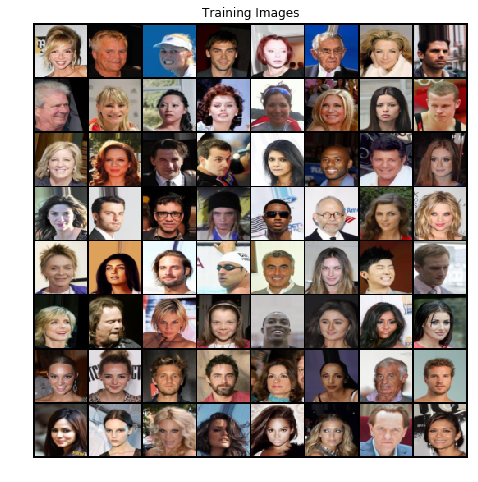

In [59]:


transform = transforms.Compose(
    [transforms.Resize(size=(64,64)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = torchvision.datasets.ImageFolder(root='./data/celebA',
                                        transform=transform)
# We need only training images
trainloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
img = vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu()
print(img.size())
plt.imshow(np.transpose(img,(1,2,0)))



In [32]:
# Generator & Discriminator Definitions
# Discriminator - Autoencoder
# Generator - Decoder

# Encoder Defn
class Encoder(torch.nn.Module):
    def __init__(self,out_channels):
        super(Encoder, self).__init__()
        self.out_c = out_channels # default - 64
        self.conv0 = torch.nn.Conv2d(3, self.out_c, 3, 1, 1) #64*64*64
        self.conv1 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #64*64*64
        self.conv2 = torch.nn.Conv2d(self.out_c, self.out_c*2, 3, 1, 1) #64*64*128
        
        # sub-sampling - stride size=2
        self.down0 = torch.nn.Conv2d(self.out_c*2, self.out_c*2, 3, 2, 1) #32*32*128
        
        self.conv3 = torch.nn.Conv2d(self.out_c*2, self.out_c*2, 3, 1, 1) #32*32*128
        self.conv4 = torch.nn.Conv2d(self.out_c*2, self.out_c*3, 3, 1, 1) #32*32*192
        
        # sub-sampling - stride size=2
        self.down1 = torch.nn.Conv2d(self.out_c*3, self.out_c*3, 3, 2, 1) #16*16*192
        
        self.conv5 = torch.nn.Conv2d(self.out_c*3, self.out_c*3, 3, 1, 1) #16*16*192
        self.conv6 = torch.nn.Conv2d(self.out_c*3, self.out_c*3, 3, 1, 1) #16*16*192
        
        # sub-sampling - stride size=2
        self.down2 = torch.nn.Conv2d(self.out_c*3, self.out_c*3, 3, 2, 1) #8*8*192
        
        self.conv7 = torch.nn.Conv2d(self.out_c*3, self.out_c*3, 3, 1, 1) #8*8*192
        self.conv8 = torch.nn.Conv2d(self.out_c*3, self.out_c*4, 3, 1, 1) #8*8*256
        
        # Fully-connected layer
        self.lin0 = torch.nn.Linear(8*8*4*self.out_c, 64) # h - 64
        
    def forward(self, input):
        x = self.conv0(input)
        x = torch.nn.ELU(True)(x)
        x = self.conv1(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv2(x)
        x = torch.nn.ELU(True)(x)
        
        x = self.down0(x)
        
        x = self.conv3(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv4(x)
        x = torch.nn.ELU(True)(x)
        
        x = self.down1(x)
        
        x = self.conv5(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv6(x)
        x = torch.nn.ELU(True)(x)
        
        x = self.down2(x)
        
        x = self.conv7(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv8(x)
        x = torch.nn.ELU(True)(x)
        
        x = torch.nn.Flatten()(x) 
        x = self.lin0(x)
        
        return x
    
# Decoder/Generator Defn
class Decoder(torch.nn.Module):
    def __init__(self,out_channels):
        
        super(Decoder, self).__init__()
        self.out_c = out_channels # default - 64
        # Fully-connected layer
        self.lin0 = torch.nn.Linear(64, 8*8*self.out_c) # h - 64
        self.conv0 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #8*8*64
        self.conv1 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #8*8*64
        
        # Up-sampling with nearest-neighbour
        self.up1 = torch.nn.UpsamplingNearest2d(scale_factor=2) #16*16*64
        
        self.conv2 = torch.nn.Conv2d(2*self.out_c, self.out_c, 3, 1, 1) #16*16*64
        self.conv3 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #16*16*64
        
        # Up-sampling with nearest-neighbour
        self.up2 = torch.nn.UpsamplingNearest2d(scale_factor=2) #32*32*64
        
        self.conv4 = torch.nn.Conv2d(2*self.out_c, self.out_c, 3, 1, 1) #32*32*64
        self.conv5 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #32*32*64
        
        # Up-sampling with nearest-neighbour
        self.up3 = torch.nn.UpsamplingNearest2d(scale_factor=2) #64*64*64
        
        self.conv6 = torch.nn.Conv2d(2*self.out_c, self.out_c, 3, 1, 1) #64*64*64
        self.conv7 = torch.nn.Conv2d(self.out_c, self.out_c, 3, 1, 1) #64*64*64
        
        self.conv8 = torch.nn.Conv2d(self.out_c, 3, 3, 1, 1) #64*64*3
        
    def forward(self, input):
        # Input h is 64*1
        x = self.lin0(input) #8*8*64
        x0 = x.view(-1, self.out_c, 8, 8) # we should not fix batch-size
        x = self.conv0(x0)
        x = torch.nn.ELU(True)(x)
        x = self.conv1(x)
        x = torch.nn.ELU(True)(x)
        x = self.up1(x)
        
        # We add a skipped connection here from h0
        # Upsample x0 first & concatenate with x
        x = torch.cat((torch.nn.UpsamplingNearest2d(scale_factor=2)(x0),x), dim=1)
        x = self.conv2(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv3(x)
        x = torch.nn.ELU(True)(x)
        x = self.up2(x)
        
        # Ww add 2nd skipped connection here from h0
        x = torch.cat((torch.nn.UpsamplingNearest2d(scale_factor=4)(x0),x), dim=1)
        x = self.conv4(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv5(x)
        x = torch.nn.ELU(True)(x)
        x = self.up3(x)
        
        # We add 3rd skipped connection here from h0
        x = torch.cat((torch.nn.UpsamplingNearest2d(scale_factor=8)(x0),x), dim=1)
        x = self.conv6(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv7(x)
        x = torch.nn.ELU(True)(x)
        x = self.conv8(x)
        
        x = torch.nn.Tanh()(x)
        return x
        
# Discriminator Defn. Generator Defn is Decoder        
class Discriminator(torch.nn.Module):
    
    def __init__(self, out_channels):
        super(Discriminator, self).__init__()
        self.Encoder = Encoder(out_channels)
        self.Decoder = Decoder(out_channels)
    def forward(self, input):
        return self.Decoder(self.Encoder(input))
    

In [33]:
# Initialize Generator & Discriminator
netG = Decoder(64).to(device)
netD = Discriminator(64).to(device)
print(netG)
print(netD)

Decoder(
  (lin0): Linear(in_features=64, out_features=4096, bias=True)
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Discriminator(
  (Encoder): Encoder(
    (conv0)

In [60]:
# Test Generator
# testing generator output
# Generate batch of latent vectors
noise1 = torch.empty((batch_size, 64)).uniform_(-1,1).to(device)
# Generate fake image batch with G
fake1 = netG(noise1)
print(fake1.size())

torch.Size([64, 3, 64, 64])


In [61]:
# Loss Function is pixel-wise difference between input & target
criterion = torch.nn.L1Loss()

# Generate 64 latent z vectors to check generator during training
fixed_noise = torch.empty((batch_size, 64)).uniform_(-1,1).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))


In [8]:
# Training Loop

# Lists to keep track of progress
img_list = [] # list of images generated in training
G_losses = [] # list of Generator loss
D_losses = [] # list of discriminator loss
M_global_list = [] # list of convergence measures
iters = 0 # global steps
prev_measure = 0
k_t = 0 # learning rate for 
lower_bound = 2e-6

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the trainloader
    for i, data in enumerate(trainloader, 0):
        # Update discriminator params
        # Loss_Disc = Autoencoder_loss_onrealimg - k*Autoencoder_loss_onfakeimg
        
        # Make gradients for Discriminator loss zero
        netD.zero_grad()
        
        # Auto-encoder loss on real images
        
        # Format real data batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        output = netD(real_cpu)
        errD_real = criterion(real_cpu, output)
        
        # Auto-encoder loss on fake images
        
        # Format fake data batch
        noise = torch.empty((batch_size, 64)).uniform_(-1,1).to(device)
        fake_cpu = netG(noise)
        output = netD(fake_cpu.detach())
        errD_fake = criterion(fake_cpu, output)
        
        errD = errD_real -k_t*errD_fake
        # calculate gradients
        errD.backward()
        optimizerD.step()
        
        # Update Generator params
        # Loss_Gen = Autoencoder_loss_onfakeimg
        
        # Make gradients for Generator loss zero
        netG.zero_grad()
        
        # Auto-encoder loss on fake images
        
        fake_cpu = netG(noise)
        output = netD(fake_cpu)
        errG = criterion(fake_cpu, output)
        # calculate gradients
        errG.backward()
        optimizerG.step()
        
        # Update k_t
        k_t = k_t + lambda_k*(gamma*errD_real.item() - errG.item())
        k_t = max(min(1, k_t), 0)
        
        # Convergence Measure
        M_global = errD_real.item() + np.abs(gamma*errD_real.item() - errG.item())
        
        # Every 50th batch output training stats
        # gen_loss/discrim_loss is the balance measure, M_global
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tGamma: %.4f\tM_global: %.4f'
                  % (epoch, epochs, i, len(trainloader),
                     errD.item(), errG.item(), errG.item()/errD_real.item(), M_global))

        # Save Losses & Convergence Measures for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        M_global_list.append(M_global)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img = vutils.make_grid(fake, padding=2, normalize=True).cpu()
                plt.imsave('./gen_images/gen_img%d.png'%iters,np.transpose(img.numpy(),(1,2,0)))
                #print(img.size())
                #plt.imshow(np.transpose(img,(1,2,0)))
            img_list.append(img)
            
        # Check and half the learning rate if convergence measure is not changing
        if (iters % 1000 == 0):
            with torch.no_grad():
                curr_measure = np.mean(M_global_list)
                if prev_measure != 0 and curr_measure > 0.9999*prev_measure:
                    lr = min(lower_bound,lr*0.5)
                    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
                    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
                    prev_measure = curr_measure
                elif prev_measure == 0:
                    prev_measure = curr_measure
                    
            
        iters += 1
        

Starting Training Loop...
[0/100][0/3166]	Loss_D: 0.5129	Loss_G: 0.0476	Gamma: 0.0928	M_global: 0.7218
[0/100][50/3166]	Loss_D: 0.2475	Loss_G: 0.1023	Gamma: 0.4129	M_global: 0.2692
[0/100][100/3166]	Loss_D: 0.2383	Loss_G: 0.0539	Gamma: 0.2257	M_global: 0.3040
[0/100][150/3166]	Loss_D: 0.2202	Loss_G: 0.0663	Gamma: 0.3006	M_global: 0.2646
[0/100][200/3166]	Loss_D: 0.2057	Loss_G: 0.0555	Gamma: 0.2690	M_global: 0.2538
[0/100][250/3166]	Loss_D: 0.1983	Loss_G: 0.0600	Gamma: 0.3012	M_global: 0.2387
[0/100][300/3166]	Loss_D: 0.1832	Loss_G: 0.0615	Gamma: 0.3347	M_global: 0.2141
[0/100][350/3166]	Loss_D: 0.1845	Loss_G: 0.0891	Gamma: 0.4794	M_global: 0.1897
[0/100][400/3166]	Loss_D: 0.1817	Loss_G: 0.0592	Gamma: 0.3246	M_global: 0.2143
[0/100][450/3166]	Loss_D: 0.1588	Loss_G: 0.0738	Gamma: 0.4623	M_global: 0.1657
[0/100][500/3166]	Loss_D: 0.1772	Loss_G: 0.0523	Gamma: 0.2936	M_global: 0.2150
[0/100][550/3166]	Loss_D: 0.1654	Loss_G: 0.0707	Gamma: 0.4250	M_global: 0.1787
[0/100][600/3166]	Loss_D: 0.1

[1/100][1950/3166]	Loss_D: 0.1203	Loss_G: 0.0705	Gamma: 0.5610	M_global: 0.1333
[1/100][2000/3166]	Loss_D: 0.1257	Loss_G: 0.0692	Gamma: 0.5230	M_global: 0.1354
[1/100][2050/3166]	Loss_D: 0.1268	Loss_G: 0.0686	Gamma: 0.5173	M_global: 0.1349
[1/100][2100/3166]	Loss_D: 0.1268	Loss_G: 0.0679	Gamma: 0.5124	M_global: 0.1342
[1/100][2150/3166]	Loss_D: 0.1241	Loss_G: 0.0658	Gamma: 0.5061	M_global: 0.1309
[1/100][2200/3166]	Loss_D: 0.1235	Loss_G: 0.0639	Gamma: 0.4932	M_global: 0.1304
[1/100][2250/3166]	Loss_D: 0.1263	Loss_G: 0.0631	Gamma: 0.4806	M_global: 0.1338
[1/100][2300/3166]	Loss_D: 0.1264	Loss_G: 0.0687	Gamma: 0.5171	M_global: 0.1352
[1/100][2350/3166]	Loss_D: 0.1268	Loss_G: 0.0649	Gamma: 0.4899	M_global: 0.1338
[1/100][2400/3166]	Loss_D: 0.1221	Loss_G: 0.0626	Gamma: 0.4926	M_global: 0.1281
[1/100][2450/3166]	Loss_D: 0.1274	Loss_G: 0.0632	Gamma: 0.4769	M_global: 0.1355
[1/100][2500/3166]	Loss_D: 0.1249	Loss_G: 0.0766	Gamma: 0.5875	M_global: 0.1418
[1/100][2550/3166]	Loss_D: 0.1247	Loss_G

[3/100][700/3166]	Loss_D: 0.1228	Loss_G: 0.0734	Gamma: 0.5772	M_global: 0.1369
[3/100][750/3166]	Loss_D: 0.1176	Loss_G: 0.0654	Gamma: 0.5375	M_global: 0.1262
[3/100][800/3166]	Loss_D: 0.1148	Loss_G: 0.0622	Gamma: 0.5240	M_global: 0.1215
[3/100][850/3166]	Loss_D: 0.1121	Loss_G: 0.0605	Gamma: 0.5203	M_global: 0.1187
[3/100][900/3166]	Loss_D: 0.1169	Loss_G: 0.0636	Gamma: 0.5253	M_global: 0.1241
[3/100][950/3166]	Loss_D: 0.1183	Loss_G: 0.0647	Gamma: 0.5256	M_global: 0.1263
[3/100][1000/3166]	Loss_D: 0.1155	Loss_G: 0.0601	Gamma: 0.5032	M_global: 0.1198
[3/100][1050/3166]	Loss_D: 0.1150	Loss_G: 0.0645	Gamma: 0.5417	M_global: 0.1241
[3/100][1100/3166]	Loss_D: 0.1120	Loss_G: 0.0600	Gamma: 0.5158	M_global: 0.1183
[3/100][1150/3166]	Loss_D: 0.1203	Loss_G: 0.0631	Gamma: 0.5062	M_global: 0.1255
[3/100][1200/3166]	Loss_D: 0.1169	Loss_G: 0.0582	Gamma: 0.4799	M_global: 0.1237
[3/100][1250/3166]	Loss_D: 0.1224	Loss_G: 0.0634	Gamma: 0.5018	M_global: 0.1266
[3/100][1300/3166]	Loss_D: 0.1188	Loss_G: 0.06

KeyboardInterrupt: 

In [13]:
# Saving trained Model
import os
PATH = "./model_params"
torch.save({
            'Generator_state_dict': netG.state_dict(),
            'Discriminator_state_dict': netD.state_dict(),
            'Gen_optimizer_state_dict': optimizerG.state_dict(),
            'Dis_optimizer_state_dict': optimizerD.state_dict(),
            'M_global_list': M_global_list,
            'img_list':img_list,
            'k_t':k_t,
            'prev_measure':prev_measure
            }, os.path.join(PATH, 'began_model_celeba_58k_%f.tar'%gamma))

In [71]:
# Saving smaller trained Model for space-constraints on github
torch.save({
            'Generator_state_dict': trained_netG.state_dict(),
            }, os.path.join(PATH, 'began_model_small_58k_%f.tar'%gamma))

In [34]:
#########################################
# Run this cell to load pre-trained Model
#########################################
# Loading the saved Model
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
import os
PATH = "./model_params"

# Instantiate the generator
trained_netG = Decoder(64).to(device)

# Load the model to cpu. To generate images we don't need gpu
checkpoint = torch.load(os.path.join(PATH, 'began_model_small_58k_%f.tar'%gamma),map_location=torch.device('cpu'))
trained_netG.load_state_dict(checkpoint['Generator_state_dict'])

trained_netG.eval()


Decoder(
  (lin0): Linear(in_features=64, out_features=4096, bias=True)
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Animation size has reached 21077346 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


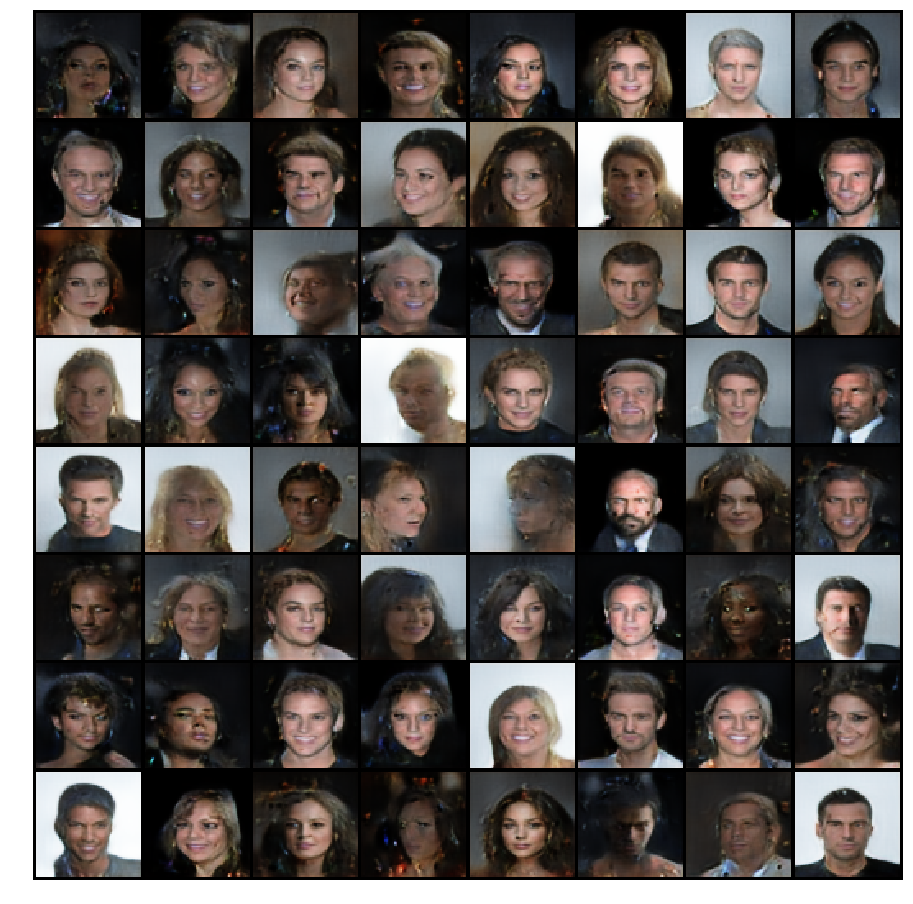

In [68]:
# Making video of images generated during training
# Generate animation of 64 images generated every 500 iterations
img_list = checkpoint['img_list']
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save('gen_images_training.mp4',writer=writer) 

tensor(1., device='cuda:0')


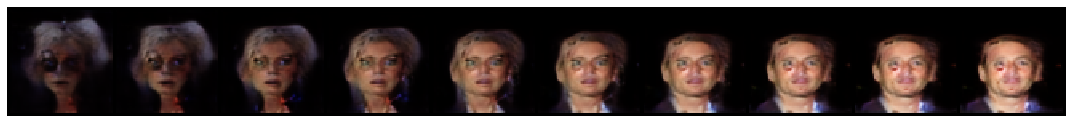

In [42]:
# Experiments on the trained Generator 

# Experiment-1
# 
# We will generate 2 Noise vectors & generate 10 intermediate vectors between them
# 
noise_1 = torch.empty((1, 64)).uniform_(-1,1).to(device)
noise_2 = torch.empty((1, 64)).uniform_(-1,1).to(device)

# Calculate difference vector's norm
dist_1_2 = torch.norm((noise_1-noise_2).squeeze().detach())
dist_incr = dist_1_2.item()/10.0

# Calculate difference vector's unit-vector
unit_vec = (noise_2-noise_1).squeeze().detach()/dist_1_2

# Generate 10 vectors between noise_1 and noise_2
incr_imgs = [noise_1+i*dist_incr*unit_vec.view(1,64) for i in range(1,11)]

# Generate 10 corresponding images & make grid
fake = trained_netG(torch.cat(incr_imgs,dim=0)).detach().cpu()
img = vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu().numpy()
    
# Show the 10 images
fig = plt.figure(figsize=(20,2))
plt.axis("off")
plt.imshow(np.transpose(img,(1,2,0)))

In [53]:
# Experiment - 2
#
# Generating 10 images similar to a source-image
# We will generate 10 vectors around a random noise vector within a n-ball
from torch.distributions.multivariate_normal import MultivariateNormal
diameter = 0.2
m = MultivariateNormal(torch.zeros(64), torch.eye(64)*diameter)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


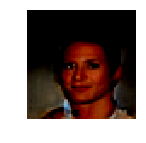

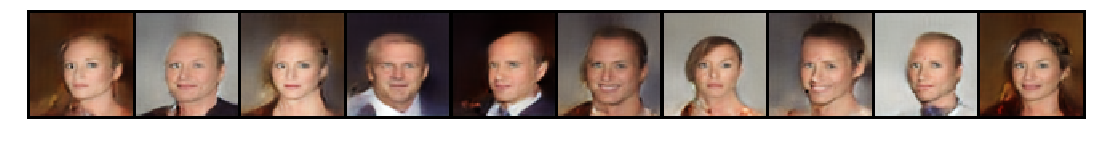

In [58]:
noise_3 = torch.empty((1, 64)).uniform_(-1,1).to(device)
unit_ball = m.sample((10,)) # 10 vectors around noise_3 at distance=diameter
sim_imgs = [noise_3+x for x in unit_ball]

# Generate 10 corresponding images & make grid
fake_source = trained_netG(noise_3).detach().cpu()
fake = trained_netG(torch.cat(sim_imgs,dim=0)).detach().cpu()
img = vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu().numpy()

# Show the source image
fig = plt.figure(figsize=(2,2))
plt.axis("off")
plt.imshow(np.transpose(fake_source.squeeze().numpy(),(1,2,0)))

# Show the 10 images similar to the source image
fig = plt.figure(figsize=(20,2))
plt.axis("off")
plt.imshow(np.transpose(img,(1,2,0)))